https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

+ 작성일: 2018-06-25

# 1. Data Import

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sales = pd.read_csv('sales_train.csv')
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# 2. EDA & Data Preprocessing

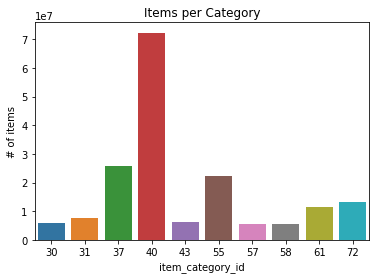

In [7]:
# item category count check
item_data = items.groupby('item_category_id').agg({'item_id':'sum'}).rename(columns = {"item_id":'count'})
item_data = item_data.sort_values(by="count", ascending=False)[0:10]
sns.barplot(x = item_data.index, y = "count",data = item_data)
plt.title("Items per Category")
plt.ylabel('# of items')
plt.show()

In [8]:
### train + items + item_categories + shops Join
sales = sales.join(shops.set_index('shop_id'))  # train + shops join by shop_id 
items_categories = item_categories.join(items.set_index('item_category_id'))    # item_categories + items join by item_category_id
sales = sales.join(items_categories.set_index('item_id'))    # train + items_categories join by item_id

# date 컬럼 포맷 수정 
sales['date'] = pd.to_datetime(sales['date'],format="%d.%m.%Y")

# year 추가 
sales['year'] = sales['date'].dt.year

# month 추가 
sales['month'] = sales['date'].dt.month

In [9]:
# group by
monthly_sales = sales.groupby(['date_block_num', 'year', 'month', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum'})
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
monthly_sales.reset_index(level=['date_block_num', 'year', 'month', 'shop_id', 'item_id'], inplace=True)
monthly_sales.head()

,date_block_num,year,month,shop_id,item_id,item_cnt_month
0,0,2013,1,0,32,6.0
1,0,2013,1,0,33,3.0
2,0,2013,1,0,35,1.0
3,0,2013,1,0,43,1.0
4,0,2013,1,0,51,2.0


C:\Users\HSChoi\Anaconda3\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


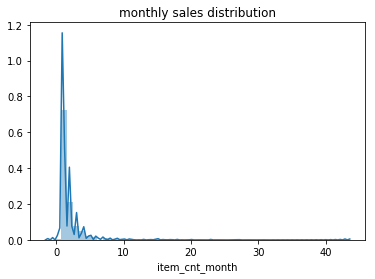

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_month, dtype: float64

In [10]:
# target distribution
data = monthly_sales['item_cnt_month']
sns.distplot(data.sample(1000))
plt.title('monthly sales distribution')
plt.show()

data.describe()

In [11]:
# item_cnt_mean 계산 : 월별 평균 아이템 판매량 
monthly_item_cnt_mean = monthly_sales.groupby(['month']).agg({'item_cnt_month':'mean'}).rename(columns={'item_cnt_month': 'item_cnt_mean'})
monthly_item_cnt_mean.reset_index(inplace=True)
monthly_sales = pd.merge(monthly_sales, monthly_item_cnt_mean, how='inner')  # merge monthly_sales & monthly_item_cnt_mean 

# 카테고리 id 추가 
monthly_sales = pd.merge(monthly_sales, items[['item_id', 'item_category_id']], how='inner') 

# sorting
monthly_sales = monthly_sales[['shop_id','item_id','item_category_id','date_block_num', 'year', 'month','item_cnt_mean','item_cnt_month']]
monthly_sales.sort_values(['shop_id','item_id','date_block_num', 'year', 'month'], inplace=True)
monthly_sales.head()

# prev_item_cnt_month 추가 
monthly_sales['prev_item_cnt_month'] = monthly_sales.groupby(['shop_id','item_id'])['item_cnt_month'].shift(1)
monthly_sales['prev_item_cnt_month'] = monthly_sales['prev_item_cnt_month'].fillna(0)
monthly_sales.head()

,shop_id,item_id,item_category_id,date_block_num,year,month,item_cnt_mean,item_cnt_month,prev_item_cnt_month
851616,0,30,40,1,2013,2,2.160486,31.0,0.0
914716,0,31,37,1,2013,2,2.160486,11.0,0.0
0,0,32,40,0,2013,1,2.200289,6.0,0.0
91,0,32,40,1,2013,2,2.160486,10.0,6.0
785,0,33,37,0,2013,1,2.200289,3.0,0.0


In [12]:
train = monthly_sales[['shop_id', 'item_category_id', 'date_block_num', 
                       'year','month', 'item_cnt_mean', 'prev_item_cnt_month', 'item_cnt_month']]

In [20]:
train.head()

,shop_id,item_category_id,date_block_num,year,month,item_cnt_mean,prev_item_cnt_month,item_cnt_month
851616,0,40,1,2013,2,2.160486,0.0,31.0
914716,0,37,1,2013,2,2.160486,0.0,11.0
0,0,40,0,2013,1,2.200289,0.0,6.0
91,0,40,1,2013,2,2.160486,6.0,10.0
785,0,37,0,2013,1,2.200289,0.0,3.0


In [13]:
# One hot encoding

from numpy import array
from numpy import argmax
from sklearn.preprocessing import OneHotEncoder

integer_encoded = train[['shop_id','item_category_id']].values
onehot_encoder = OneHotEncoder(sparse=False)   
#integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [14]:
# Train Test split
total =  np.hstack((onehot_encoded, train[['date_block_num', 'year','month', 
                                                      'item_cnt_mean', 'prev_item_cnt_month', 'item_cnt_month']]))
X_train = total[:int(total.shape[0] * 0.8),:-1]
y_train = total[:int(total.shape[0] * 0.8),-1]

X_test = total[int(total.shape[0] * 0.8):,:-1]
y_test = total[int(total.shape[0] * 0.8):,-1]

In [26]:
y_train.clip(0, 10).max()
y_test.clip(0, 10)

array([1., 1., 1., ..., 1., 2., 1.])

# 3. Modeling

In [27]:
# Utility function to report best scores# Utilit 
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [28]:
from sklearn.metrics import mean_squared_error 
def performance_check(reg, X_train, y_train, X_test, y_test):
    # TRAINING PERFORMANCE
    #reg = grid_search.best_estimator_
    pred = reg.predict(X_train)
    train_err = np.sqrt(mean_squared_error(y_train, pred))
    print("Train ERROR: ", train_err)

    # TEST PERFORMANCE
    pred = reg.predict(X_test)
    test_err = mean_squared_error(y_test, pred)
    print("TEST ERROR: ", test_err)
    
    return train_err,test_err

In [29]:
X_train = X_train[:30000]
y_train = y_train[:30000]
X_test = X_test[:30000]
y_test = y_test[:30000]

## 3.1 Random Forest Regerssion

In [30]:
RANDOM_SEED=5

In [35]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor

print(__doc__)

# build a classifier
reg = RandomForestRegressor(random_state=RANDOM_SEED)
# use a full grid over all parameters
param_grid={"max_depth": [8, 16, 32, 64, 128]}

start = time()
# run grid search
grid_search = GridSearchCV(reg, param_grid=param_grid, 
                           scoring ="neg_mean_absolute_error", cv=5)
grid_search.fit(X_train, y_train.clip(0, 20))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

Automatically created module for IPython interactive environment


TypeError: Singleton array array(<built-in method clip of numpy.ndarray object at 0x000001DB897F1F80>,
      dtype=object) cannot be considered a valid collection.

In [34]:
reg = grid_search.best_estimator_
rf_train_err, rf_test_err = performance_check(reg, X_train, y_train.clip(0, 20), X_test, y_test.clip(0, 20))

Train ERROR:  1.6745257671967073
TEST ERROR:  2.769927272898828


## 3.2 Artificial Neural Network

In [38]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.neural_network import MLPRegressor

print(__doc__)

# build a classifier
reg = MLPRegressor(random_state=RANDOM_SEED)
# use a full grid over all parameters
param_grid={"hidden_layer_sizes": [(256, 128, 256), 
                                   (256, 128, 128, 256)],
            "alpha": np.logspace(-1, 1, 3)}

start = time()
# run grid search
grid_search = GridSearchCV(reg, param_grid=param_grid, 
                           scoring ="neg_mean_absolute_error", cv=5)
grid_search.fit(X_train, y_train.clip(0, 20))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


Automatically created module for IPython interactive environment
GridSearchCV took 255.67 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: -1.024 (std: 0.266)
Parameters: {'hidden_layer_sizes': (256, 128, 256), 'alpha': 0.1}

Model with rank: 2
Mean validation score: -1.151 (std: 0.377)
Parameters: {'hidden_layer_sizes': (256, 128, 128, 256), 'alpha': 0.1}

Model with rank: 3
Mean validation score: -1.265 (std: 0.403)
Parameters: {'hidden_layer_sizes': (256, 128, 128, 256), 'alpha': 10.0}

Model with rank: 4
Mean validation score: -1.265 (std: 0.408)
Parameters: {'hidden_layer_sizes': (256, 128, 128, 256), 'alpha': 1.0}

Model with rank: 5
Mean validation score: -1.293 (std: 0.273)
Parameters: {'hidden_layer_sizes': (256, 128, 256), 'alpha': 1.0}

Model with rank: 6
Mean validation score: -1.379 (std: 0.382)
Parameters: {'hidden_layer_sizes': (256, 128, 256), 'alpha': 10.0}



In [39]:
reg = grid_search.best_estimator_
ann_train_err, ann_test_err = performance_check(reg, X_train, y_train.clip(0, 20), X_test, y_test.clip(0, 20))

Train ERROR:  2.357640216148715
TEST ERROR:  3.9555767296682034


## 3.3 Gradient Boosting

In [40]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

print(__doc__)

# build a classifier
reg = GradientBoostingRegressor(n_estimators = 5, random_state=RANDOM_SEED)
# use a full grid over all parameters
param_grid={"max_depth": [8, 16, 32],
            "min_samples_split": [2, 4, 8]}

# run grid search
grid_search = GridSearchCV(reg, param_grid=param_grid, 
                           scoring ="neg_mean_absolute_error", cv=3)
start = time()
grid_search.fit(X_train, y_train.clip(0, 20))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

Automatically created module for IPython interactive environment
GridSearchCV took 47.23 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: -1.145 (std: 0.097)
Parameters: {'max_depth': 16, 'min_samples_split': 8}

Model with rank: 2
Mean validation score: -1.149 (std: 0.091)
Parameters: {'max_depth': 8, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: -1.149 (std: 0.092)
Parameters: {'max_depth': 8, 'min_samples_split': 2}

Model with rank: 4
Mean validation score: -1.150 (std: 0.097)
Parameters: {'max_depth': 16, 'min_samples_split': 4}

Model with rank: 5
Mean validation score: -1.150 (std: 0.091)
Parameters: {'max_depth': 8, 'min_samples_split': 4}

Model with rank: 6
Mean validation score: -1.151 (std: 0.097)
Parameters: {'max_depth': 16, 'min_samples_split': 2}

Model with rank: 7
Mean validation score: -1.153 (std: 0.105)
Parameters: {'max_depth': 32, 'min_samples_split': 8}

Model with rank: 8
Mean validation score: -1.156 (s

In [41]:
reg = grid_search.best_estimator_
grb_train_err, grb_test_err = performance_check(reg, X_train, y_train.clip(0, 20), X_test, y_test.clip(0, 20))

Train ERROR:  1.9622260512156369
TEST ERROR:  3.173738073631406


# 4. Model Selection

[2.357640216148715, 1.6745257671967073, 1.9622260512156369]


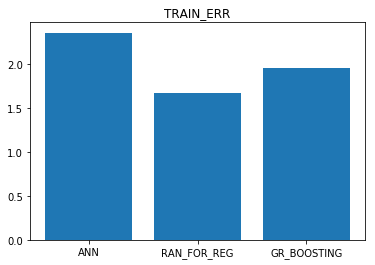

[2.357640216148715, 1.6745257671967073, 1.9622260512156369]


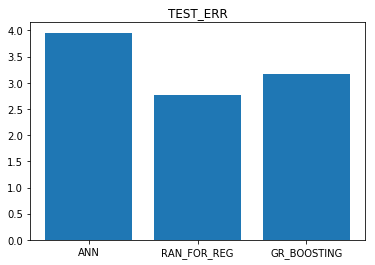

[3.9555767296682034, 2.769927272898828, 3.173738073631406]


In [42]:
list_reg = ['ANN', "RAN_FOR_REG", "GR_BOOSTING"]
list_train_err = [ann_train_err, rf_train_err, grb_train_err]
list_test_err = [ann_test_err, rf_test_err, grb_test_err]

print(list_train_err)
plt.bar(list_reg, list_train_err)
plt.title('TRAIN_ERR')
plt.show()
print(list_train_err)


plt.bar(list_reg, list_test_err)
plt.title('TEST_ERR')
plt.show()
print(list_test_err)